In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, bs4
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sys
import string
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import SGDClassifier

%matplotlib inline

In [87]:
raw_data = pd.read_csv("train_split.csv")

In [88]:
pos = raw_data[raw_data['label'] == 1].shape[0]
neg = raw_data[raw_data['label'] == 0].shape[0]
diff = pos - neg
print(f'Позитивных отзывов - {pos}, негативных - {neg}, разница - {diff}')

Позитивных отзывов - 14009, негативных - 9426, разница - 4583


In [89]:
shuffled_data = raw_data.sample(frac=1,random_state=4)

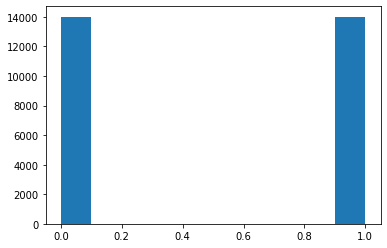

In [90]:
fraud_data = shuffled_data.loc[shuffled_data['label'] == 1]
non_fraud_data = shuffled_data.loc[shuffled_data['label'] == 0].sample(n=diff, random_state=10, replace=True, axis = 0)
overbalanced_data = pd.concat([fraud_data, non_fraud_data, shuffled_data.loc[shuffled_data['label'] == 0]])

plt.hist(overbalanced_data['label']);

In [91]:
X_train = overbalanced_data.text.values
y_train = overbalanced_data.label.values

In [92]:
test_data = pd.read_excel('преобразованный файл Test.xlsx', encoding=sys.getfilesystemencoding())
X_test = []
temp_row = ''

for row in test_data.Column1.values:
    if row.find('<review>') != -1:
        temp_row = row.replace('<review>', '')
    elif row.find('</review>') != -1:
        X_test.append(temp_row + row.replace('</review>', ''))
    else:
        temp_row = temp_row + row

In [93]:
def clean_data(X_data):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    for i in np.arange(len(X_data)):
#       приведение к нижнему регистру и замена "ё" на "е"
        X_data[i] = X_data[i].lower().replace("ё", "е")
#       очистка от цифр и английских слов
        X_data[i] = re.sub(r"[A-Za-z0-9]", " ", X_data[i])
#       очистка от переносов строк
        X_data[i] = re.sub(r"\r\n|\r|\n", " ", X_data[i])
#       очистка от пунктуации 
        X_data[i] = X_data[i].translate(replace_punctuation)
#       очистка от лишних пробелов  
        X_data[i] = " ".join(X_data[i].split())

In [95]:
clean_data(X_train)
clean_data(X_test)

In [72]:
stopwords = set(nltk_stopwords.words('russian') )

In [74]:
param_grid = {'vectorizer__stop_words': [None, stopwords],
              'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'vectorizer__analyzer': ['word', 'char'],
              'vectorizer__min_df': [10, 20, 30]}

In [75]:
log_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [97]:
log_reg = GridSearchCV(log_pipeline, param_grid, n_jobs=-1)
log_reg = log_reg.fit(X_train, y_train)

In [98]:
print("Best score found by grid search:")
print(log_reg.best_score_)

Best score found by grid search:
0.8766865359551061


In [99]:
print(log_reg.best_params_)

{'vectorizer__analyzer': 'word', 'vectorizer__min_df': 10, 'vectorizer__ngram_range': (1, 4), 'vectorizer__stop_words': None}


In [100]:
log_pipeline_count = Pipeline(
            [("vectorizer", CountVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [101]:
log_reg_count = GridSearchCV(log_pipeline_count, param_grid, n_jobs=-1)
log_reg_count = log_reg_count.fit(X_train, y_train)

In [102]:
print("Best score found by grid search:")
print(log_reg_count.best_score_)

Best score found by grid search:
0.8873577018429636


In [103]:
res = log_reg_count.best_estimator_.predict(X_test)

In [104]:
for vote_i in np.arange(len(X_test)):
    print(res[vote_i])
    print(X_test[vote_i])
    print()

0
ужасно слабый аккумулятор это основной минус этого аппарата разряжается буквально за пару часов при включенном и на макс подсветке например если играть или смотреть видео следовательно использовать можно только если есть постоянная возможность подзарядиться качества звука через динамик далеко не на высоте наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню очень мало встроенной памяти а приложения устанавливаются именно туда с этим связанны неудобства нужно постоянно переносить их на карту памяти несколько неудобно что нету отдельной кнопки для фото подумываю купить батарею большей емкость мб что нибудь измениться

1
цена надежность неубиваемость долго держит батарею дня стабильно как телефон как плеер если постоянно долбиться в уши и звонить по паре часо на дню игры и конечно смс в месяц около шт набирается максимальное время работы дней в щадящем режиме рулит после нее набор смс на обычных сенсорниках и кнопочных просто издивательство громкий чистый звук хоро

In [106]:
res2 = log_reg.best_estimator_.predict(X_test)

In [108]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res2]
res_df.to_csv('logreg_submission_Tfidf.csv', index=False)

In [110]:
param_grid = {'vectorizer__stop_words': [None, stopwords],
              'vectorizer__analyzer': ['word', 'char'],
              'classifier__penalty': ['l1', 'l2'],
              'classifier__alpha': [0.01, 0.001, 0.0001],
              'classifier__max_iter': [100, 500, 1000]}

SGD_pipeline = Pipeline(
            [("vectorizer", CountVectorizer(ngram_range=(1,4), min_df = 10)),
             ("classifier", SGDClassifier(random_state=42))])

In [111]:
clf_SGD = GridSearchCV(SGD_pipeline, param_grid, n_jobs=-1)
clf_SGD = clf_SGD.fit(X_train, y_train)

In [112]:
print("Best score found by grid search:")
print(clf_SGD.best_score_)

Best score found by grid search:
0.8815040963448382


In [113]:
res3 = clf_SGD.best_estimator_.predict(X_test)

In [114]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res3]
res_df.to_csv('SVM.csv', index=False)